In [1]:
import numpy as np
import numpy.typing as npt
import scipy
import scipy.signal as sig
import scipy.io.wavfile as wav

import matplotlib.pyplot as plt
import IPython.display as ipd

## 1. TFCT


### 1.1 Généralités


#### a) 

$$
\begin{aligned}
\tilde{X_0}(b, f_0) &= \sum_{n \in \Z} x(n)w(n - b)e^{-2j\pi f_0 n}
\\
&= \left (y_{f_0} * w_- \right)(b)
\\
\end{aligned}
$$
Où :
$$
\begin{aligned}
y_{f_0}(n) &= x(n)e^{-2j\pi f_0 n}
\\
w_-(n) &= w(-n)
\end{aligned}
$$
La fenêtre va opérer un filtrage passe-bas dont la fréquence de coupure
est dictée par sa longueur.

#### b)

On peut écrire :
$$
\begin{aligned}
\tilde{X_{loc}}(b, f_0) &= \sum_{n \in \Z} x(n + b)w(n)e^{-2j\pi f_0 n}
\\
&= \sum_{n \in \Z} x(n)w(n - b)e^{-2j\pi f_0 (n - b)}
\\ 
&= \left ( x * h_{f_0} \right)(b)
\\
&= e^{2j\pi f_0 b} \tilde{X_0}(b, f_0)
\end{aligned}
$$
Où :
$$
\begin{aligned}
h_{f_0}(n) &= w(-n) e^{-2j\pi f_0 n}
\end{aligned}
$$

La fenêtre va opérer un filtrage passe-bande centré sur $f_0$.
La convention utilisée dans `tftc.m` est la convention passe-bande, 
car on écrit la TFTC du signal en $b$ en utilisant seulement les 
échantillons précédents de $x$.

#### c)

In [33]:

audio_dir = "../donnees"
audio_name = 'salsa.wav' 

audio_file = os.path.join(audio_dir, audio_name)
sr, s = wav.read(audio_file)
if s.ndim == 2:
    s = s[:, 0]

ipd.Audio(s, rate=sr)

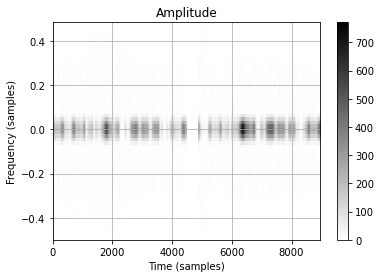

In [26]:
def stft(x: np.ndarray, w: np.ndarray, n_fft: int, r: int) -> np.ndarray:
    m = w.shape[0]
    assert(m < n_fft)
    nb_frames = (x.shape[0] - m) // r
    #
    x_loc  = np.empty((nb_frames, n_fft), dtype=np.complex128)
    frame_starts = np.arange(nb_frames)*r
    for p in np.arange(nb_frames):
        frame_start = frame_starts[p]
        frame_stop = frame_start + m
        x_w = x[frame_start:frame_stop] * w
        x_loc[p] = np.fft.fft(x_w, n=n_fft)
    times = frame_starts
    freqs = np.fft.fftfreq(n=n_fft)
    return x_loc, times, freqs

def plot_stft(x_loc: np.ndarray, times: np.ndarray, freqs: np.ndarray) -> None:
    f = np.fft.fftshift(freqs)
    x_ft_plot = np.fft.fftshift(x_loc).T
    plt.figure()
    plt.title('Amplitude')
    plt.imshow(np.abs(x_ft_plot), origin='lower', aspect='auto', 
        extent=[times[0], times[-1], f[0], f[-1]],
        interpolation='nearest')
    plt.colorbar()
    plt.set_cmap('gray_r')
    plt.xlabel('Time (samples)')
    plt.ylabel('Frequency (samples)')
    plt.grid(True)

n_fft = 64
m = 32
r = 1

t_start = 1000
t_stop = 10000

w = sig.windows.blackman(m)
x = s[t_start:t_stop]
x_loc, times, freqs = stft(x, w, n_fft, r)
plot_stft(x_loc, times, freqs)

$x_k(p)$ est complexe. Pour $f_k$ fixé, on peut exprimer la 
TFCT de $x$

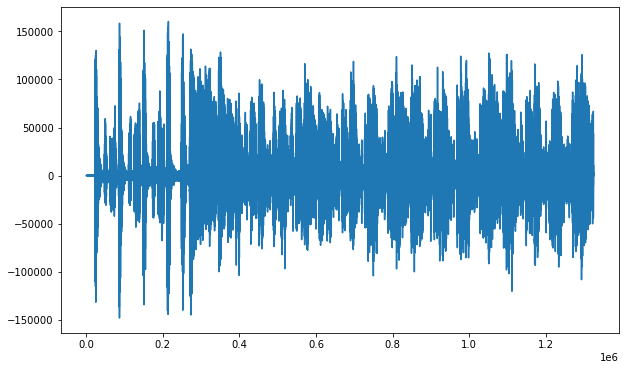

In [30]:
def stft_filter(x: np.ndarray, w: np.ndarray, n_fft: int, r: int, k: int) -> np.ndarray:
    m = w.shape[0]
    assert(m < n_fft)
    assert(k < n_fft)
    #
    #
    h_k = w[::r]* np.exp(- 2j * np.pi * k / n_fft * np.arange(w.shape[0]))
    x_loc_k = np.convolve(x, h_k, mode='same')
    #
    return x_loc_k

n_fft = 64
m = 32

r = 1
k = 12

t_start = 1000
t_stop = 100000

w = sig.windows.blackman(m)
x_loc_k = stft_filter(s, w, n_fft, r, k)

plt.figure(figsize=(10, 6))
plt.plot(np.real(x_loc_k))

ipd.Audio(np.real(x_loc_k), rate=sr)

À l'écoute de $Re(x_k)$, on entend bien le résultat d'un filtrage passe-bande.


### 1.2 Reconstruction

#### d)

$$
    y(n) = \sum_{m \in \Z} x(m) \left (\sum_{p \in \Z} w(m-pR)w_s(n-pR) \right ) \frac{1}{N}\sum_{k=0}^{N-1} \left ( e^{-2j\pi \frac{m - n}{N}}  \right )^{k}
$$
or :
$$
    \frac{1}{N} \sum_{k=0}^{N-1} \left ( e^{-2j\pi \frac{m - n}{N}}  \right )^{k} = \delta_{m,n}
$$
d'où :
$$
\begin{aligned}
    y(n) &= x(n) \sum_{p \in \Z} w(n-pR)w_s(n-pR)
   \\ 
    &= x(n) \chi(n)
\end{aligned}
$$


(7792, 1024) (7792, 256)
(498944,)


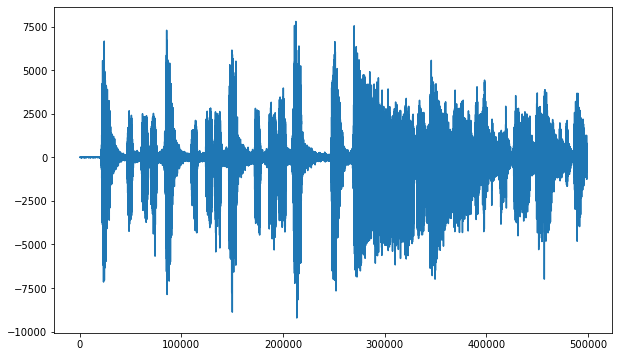

In [39]:
def ola(x_loc: npt.NDArray[np.complex128], w_s: npt.NDArray[float], r: int) -> npt.NDArray[np.complex128]:
    nb_frames = x_loc.shape[0]
    n_fft = x_loc.shape[1]
    m = w_s.shape[0]
    n_t = m + nb_frames * r
    y_s = w_s * np.fft.ifft(x_loc, n=m,axis=-1)
    print(x_loc.shape, y_s.shape)
    y = np.zeros(n_t, dtype=np.complex128)
    for p in np.arange(nb_frames):
        frame_start = p*r
        frame_stop = frame_start + m
        y[frame_start:frame_stop] = y_s[p]
    return y


n_fft = 1024
m = 128
r = m//4

t_start = 1000
t_stop = 500000
x = s[t_start:t_stop]

w = sig.windows.hann(m)
w_s = w

x_loc, times, freqs = stft(x, w, n_fft, r)
y = ola(x_loc, w_s, r)
print(y.shape)

plt.figure(figsize=(10, 6))
plt.plot(np.real(y))

ipd.Audio(np.real(y), rate=sr)